In [16]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import model_from_json

In [4]:
train_dir = '/Users/ada/Desktop/archive/train/'
test_dir = '/Users/ada/Desktop/archive/test/'
row = col = 48
emotions = 7

def count_exp(path, set_):
    dic = {}
    for emo in os.listdir(path):
        direct = path + emo
        dic[emo] = len(os.listdir(direct))
    df = pd.DataFrame(dic, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)



       happy   sad  fear  surprise  neutral  angry  disgust
train   7215  4830  4097      3171     4965   3995      436
      happy   sad  fear  surprise  neutral  angry  disgust
test   1774  1247  1024       831     1233    958      111


<AxesSubplot: >

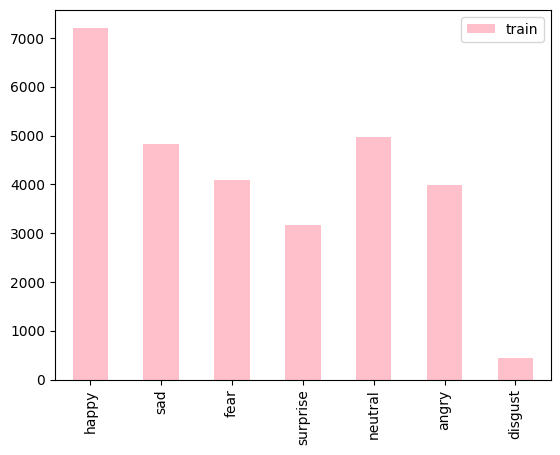

In [9]:
train_count.transpose().plot(kind="bar",color="pink")

<AxesSubplot: >

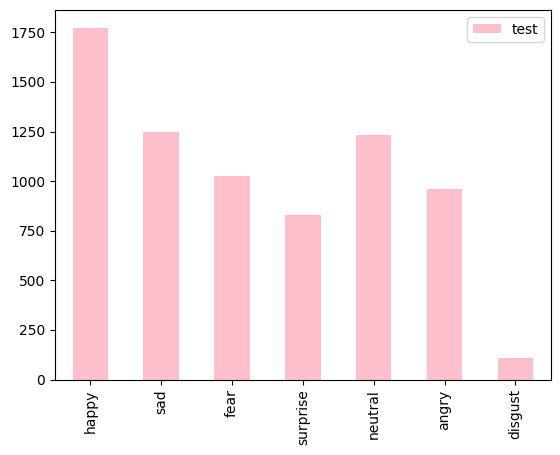

In [4]:
test_count.transpose().plot(kind="bar",color="pink")

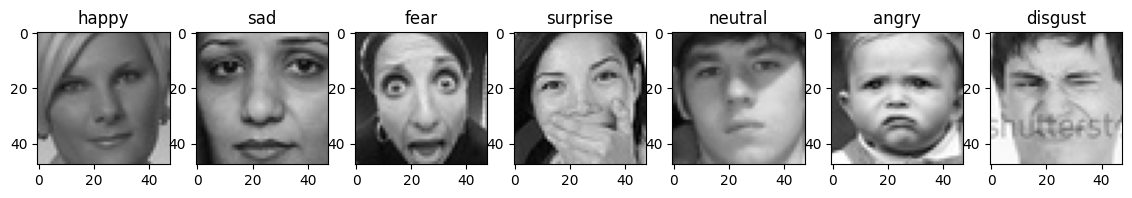

In [5]:
plt.figure(figsize=(14,22))
x = 1
for emo in os.listdir(train_dir):
    image = load_img((train_dir + emo + '/' + os.listdir(train_dir + emo)[1]))
    plt.subplot(1,7,x)
    plt.title(emo)
    plt.imshow(image)
    x += 1
plt.show()

In [10]:
train_gen = ImageDataGenerator(rescale=1./255,zoom_range=0.3,horizontal_flip=True)
train_set = train_gen.flow_from_directory(train_dir,batch_size=64,target_size=(48,48),
                                                shuffle=True,color_mode='grayscale',class_mode='categorical')
test_gen = ImageDataGenerator(rescale=1./255)
test_set = test_gen.flow_from_directory(test_dir,batch_size=64,target_size=(48,48),
                                                shuffle=True,color_mode='grayscale',class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [11]:
train_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [12]:
def my_model(input_size, classes=7):
    #initilaze CNN
    model = Sequential()   
    #Layer 1
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))
    #Layer 2
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))
    model.compile(loss="categorical_crossentropy",
              optimizer=Adam(),
              metrics=['accuracy'])
    return model

In [13]:
fer_model = my_model((row,col,1), emotions)
fer_model.summary()

2023-02-02 21:57:47.954853: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

In [ ]:
epoch = train_set.n // train_set.batch_size
validsteps = test_set.n // test_set.batch_size

hist = fer_model.fit(x=train_set,
                 validation_data=test_set,
                 epochs=60,
                 steps_per_epoch=epoch,
                 validation_steps=validsteps)

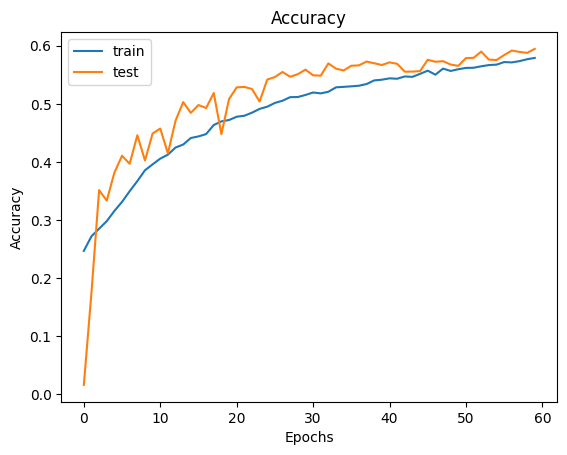

In [16]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

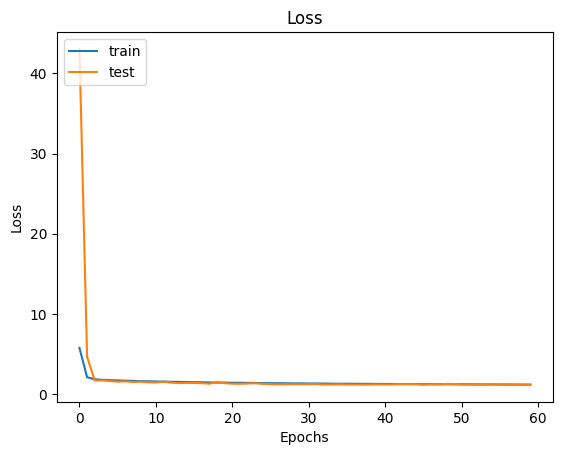

In [15]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
train_loss, train_accu = fer_model.evaluate(train_set)
test_loss, test_accu = fer_model.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 26s 227ms/step - loss: 1.1434 - accuracy: 0.5946
final train accuracy = 63.80 , validation accuracy = 59.46


In [13]:
fer_json = fer_model.to_json()
with open("fer.json", "w") as json_file:
    json_file.write(fer_json)
fer_model.save_weights("fer.h5")

In [ ]:
pred = fer_model.predict(test_set)
pred = np.argmax(pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

In [19]:
model = model_from_json(open("fer.json", "r").read())
model.load_weights('fer.h5')

In [5]:
test_prep = ImageDataGenerator(
    rescale = 1/255.,
    )
test_generator = test_prep.flow_from_directory(
    test_dir,
    class_mode= "categorical",
    target_size = (row, col),
    color_mode = "grayscale",
    shuffle = True,
    batch_size=64
)

Found 7178 images belonging to 7 classes.


In [6]:
emotion = ['Angry', 
            'Disgust', 
            'Fear', 
            'Happy', 
            'Neutral', 
            'Sad', 
            'Surprise']

In [ ]:
random_batch = np.random.randint(0, len(test_generator)-1)
random_img_ind = np.random.randint(0, 63, 10)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    rand_img = test_generator[random_batch][0][random_img_ind[i]]
    rand_lab = np.argmax(test_generator[random_batch][1][random_img_ind[i]])
    pred = np.argmax(fer_model.predict( tf.expand_dims(rand_img, axis=0) , verbose=0))
    ax.imshow(rand_img)
    if emotion[rand_lab] == emotion[pred]: color = "blue"
    else: color = "red"
    ax.set_title(f"True: {emotion[rand_lab]}\nPredicted: {emotion[pred]}", color=color)
plt.show()
plt.tight_layout()

In [ ]:
cm = confusion_matrix(test_set.classes, pred)
print("Confusion Matrix\n", cm)

In [27]:
print('Classification Report')
print(classification_report(test_set.classes, pred, target_names=list(class_labels.values())))

Classification Report
              precision    recall  f1-score   support

       angry       0.15      0.13      0.14       958
     disgust       0.00      0.00      0.00       111
        fear       0.15      0.09      0.11      1024
       happy       0.24      0.27      0.25      1774
     neutral       0.17      0.26      0.21      1233
         sad       0.18      0.15      0.17      1247
    surprise       0.11      0.11      0.11       831

    accuracy                           0.18      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.18      0.17      7178



([<matplotlib.axis.YTick at 0x141e4c3d0>,
 [Text(0, 0, 'angry'),
  Text(0, 1, 'disgust'),
  Text(0, 2, 'fear'),
  Text(0, 3, 'happy'),
  Text(0, 4, 'neutral'),
  Text(0, 5, 'sad'),
  Text(0, 6, 'surprise')])

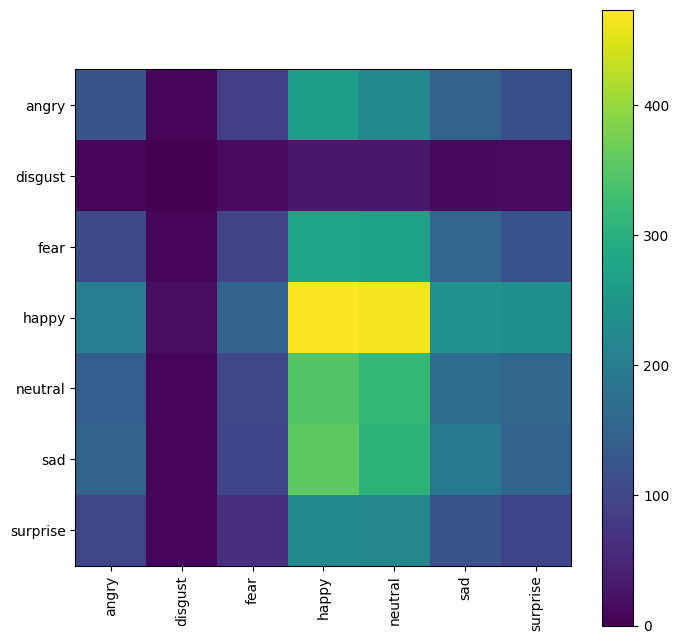

In [28]:
plt.figure(figsize=(8,8))
plt.imshow(cm, interpolation='nearest')
plt.colorbar()
n = list(class_labels.values())
tick_mark = np.arange(len(n))
plt.xticks(tick_mark, n, rotation=90)
plt.yticks(tick_mark, n)